# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

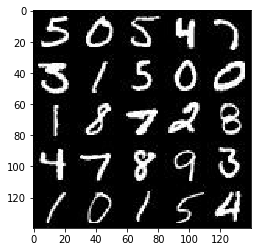

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

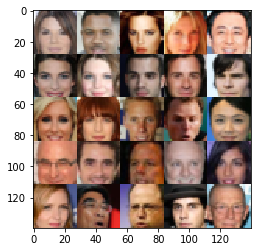

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32,shape=(None,image_width, image_height, image_channels),name="real_input")
    fake_input = tf.placeholder(tf.float32,shape=(None,z_dim),name="fake_input")
    learning_rate = tf.placeholder(tf.float32,shape=(),name="learning_rate")

    return real_input, fake_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha=0.1
    with tf.variable_scope("discriminator",reuse=reuse):
        #28x28x3
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(x1*alpha,x1)
        #relu1 = tf.nn.dropout(relu1,0.6)
        #14x14x64
        x2 = tf.layers.conv2d(relu1,128,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(bn2*alpha,bn2)
        #relu2 = tf.nn.dropout(relu2,0.6)
        #14x14x128
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(bn3*alpha,bn3)
        #relu3 = tf.nn.dropout(relu3,0.6)
        #7x7x256
        x4 = tf.layers.conv2d(relu3,512,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4,training=True)
        relu4 = tf.maximum(bn4*alpha,bn4)
        #relu4 = tf.nn.dropout(relu4,0.6)
        #7x7x512
        flat = tf.reshape(relu4,(-1,7*7*512))
        logits= tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.1
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z,7*7*1024)
        x1 = tf.reshape(x1,(-1,7,7,1024))
        x1 = tf.layers.batch_normalization(x1,training=True)
        x1 = tf.maximum(x1*alpha,x1)
        #7x7x1024
        x2 = tf.layers.conv2d_transpose(x1,512,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(x2*alpha,x2)
        #x2 = tf.nn.dropout(x2,0.5)
        #7x7x512
        x3 = tf.layers.conv2d_transpose(x2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(x3*alpha,x3)
        #x3 = tf.nn.dropout(x3,0.5)
        #14x14x256
        x4 = tf.layers.conv2d_transpose(x3,128,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4,training=is_train)
        x4 = tf.maximum(x4*alpha,x4)
        #x4 = tf.nn.dropout(x4,0.5)
        #14x14x128
        x5 = tf.layers.conv2d_transpose(x4,64,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5,training=is_train)
        x5 = tf.maximum(x5*alpha,x5)
        #x5 = tf.nn.dropout(x5,0.5)
        #14x14x64
        logits = tf.layers.conv2d_transpose(x5,out_channel_dim,5,strides=2,padding='same')
        #28x28x3
        out= tf.tanh(logits)
    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*np.random.uniform(0.7,1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.0,0.3)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step=0
    losses = []
    input_real,input_fake, lr_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real,input_fake,data_shape[3])
    d_train_opt,g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step +=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt,feed_dict={input_real:batch_images,input_fake:batch_z,lr_rate:learning_rate})
                _ = sess.run(g_train_opt,feed_dict={input_real:batch_images,input_fake:batch_z})
                #_ = sess.run(g_train_opt,feed_dict={input_real:batch_images,input_fake:batch_z})
                
                if step%10==0:
                    train_loss_d = d_loss.eval({input_real:batch_images,input_fake:batch_z})
                    train_loss_g = g_loss.eval({input_fake:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if step%100 ==0 or step == 1:
                    show_generator_output(sess, 25, input_fake, data_shape[3], data_image_mode)
        show_generator_output(sess, 25, input_fake, data_shape[3], data_image_mode)
        print("Done")        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

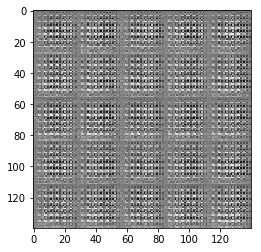

Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 2.4359
Epoch 1/2... Discriminator Loss: 3.2095... Generator Loss: 0.2785
Epoch 1/2... Discriminator Loss: 3.7851... Generator Loss: 5.0424
Epoch 1/2... Discriminator Loss: 2.4174... Generator Loss: 0.8519
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 2.4194
Epoch 1/2... Discriminator Loss: 1.9522... Generator Loss: 0.8096
Epoch 1/2... Discriminator Loss: 2.8945... Generator Loss: 4.7864
Epoch 1/2... Discriminator Loss: 3.3904... Generator Loss: 4.8157
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 3.2170
Epoch 1/2... Discriminator Loss: 1.9039... Generator Loss: 0.6731


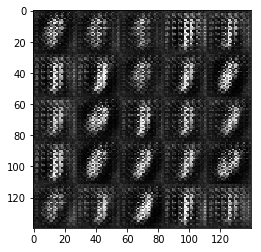

Epoch 1/2... Discriminator Loss: 4.3185... Generator Loss: 5.4326
Epoch 1/2... Discriminator Loss: 2.4904... Generator Loss: 0.3625
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 1.4585
Epoch 1/2... Discriminator Loss: 2.6784... Generator Loss: 2.9653
Epoch 1/2... Discriminator Loss: 2.1153... Generator Loss: 2.4688
Epoch 1/2... Discriminator Loss: 3.7301... Generator Loss: 3.9564
Epoch 1/2... Discriminator Loss: 2.0186... Generator Loss: 2.3704
Epoch 1/2... Discriminator Loss: 2.1650... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.9995... Generator Loss: 2.0379
Epoch 1/2... Discriminator Loss: 1.9362... Generator Loss: 0.7422


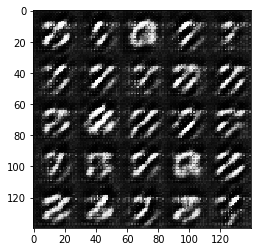

Epoch 1/2... Discriminator Loss: 2.0392... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 1.0391
Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 1.1907
Epoch 1/2... Discriminator Loss: 1.8022... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 1.9539... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 1.4018
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 1.5010
Epoch 1/2... Discriminator Loss: 2.2883... Generator Loss: 1.8336
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 1.3511
Epoch 1/2... Discriminator Loss: 1.6841... Generator Loss: 1.5993


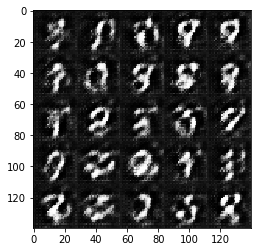

Epoch 1/2... Discriminator Loss: 2.1713... Generator Loss: 0.3789
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 1.6336... Generator Loss: 1.1500
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.6194... Generator Loss: 1.0990
Epoch 1/2... Discriminator Loss: 2.3820... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 2.1499... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.7584... Generator Loss: 1.5572
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.5994


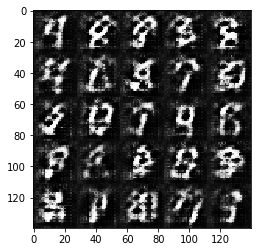

Epoch 1/2... Discriminator Loss: 1.6909... Generator Loss: 0.6115
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.6092... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 2.2584
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 2.3068
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 1.7305
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 3.5763... Generator Loss: 4.6806
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 1.1537


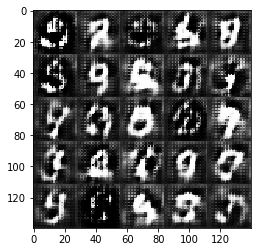

Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 1.3611
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 0.9311... Generator Loss: 1.4398
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 1.0096
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 1.8638
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 1.6633
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 1.3246
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 1.7941
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 1.8108


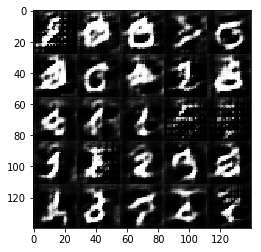

Epoch 1/2... Discriminator Loss: 1.5583... Generator Loss: 0.9756
Epoch 1/2... Discriminator Loss: 1.8081... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 1.9807
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 1.8880... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 1.9610
Epoch 1/2... Discriminator Loss: 2.3138... Generator Loss: 0.4228
Epoch 1/2... Discriminator Loss: 2.2747... Generator Loss: 2.3403
Epoch 1/2... Discriminator Loss: 1.9799... Generator Loss: 1.9519
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 1.1493


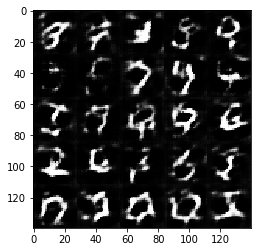

Epoch 1/2... Discriminator Loss: 1.6449... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.6991... Generator Loss: 1.7773
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 1.2361
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.5293
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 1.2870


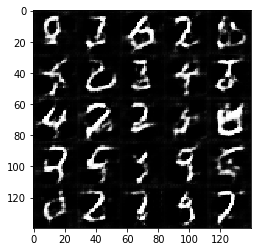

Epoch 1/2... Discriminator Loss: 1.5583... Generator Loss: 0.5677
Epoch 1/2... Discriminator Loss: 2.1050... Generator Loss: 2.4871
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.9127
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 1.5253
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 2.1144... Generator Loss: 2.4497
Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 0.7181


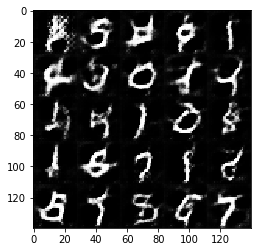

Epoch 1/2... Discriminator Loss: 1.6576... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 1.4280
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 1.5544... Generator Loss: 1.4737
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 1.7341... Generator Loss: 0.5517
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 1.0784
Epoch 1/2... Discriminator Loss: 1.5671... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 0.8975


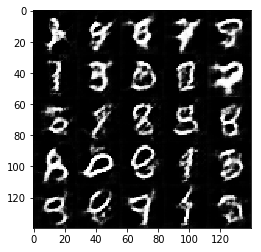

Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.7921
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 1.6137... Generator Loss: 1.6678
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 1.7198... Generator Loss: 1.3589
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 1.2059
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 1.0400


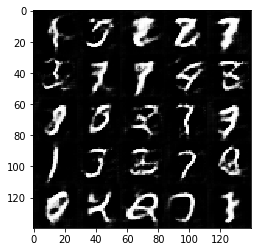

Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 1.2667
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.9554
Epoch 1/2... Discriminator Loss: 1.6902... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.5370... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 1.5347... Generator Loss: 1.3272


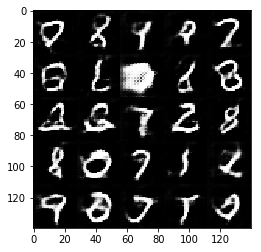

Epoch 1/2... Discriminator Loss: 1.5288... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.5788... Generator Loss: 1.5596
Epoch 1/2... Discriminator Loss: 1.7197... Generator Loss: 2.2394
Epoch 1/2... Discriminator Loss: 1.7091... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 1.4094
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 1.3227
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 1.1499


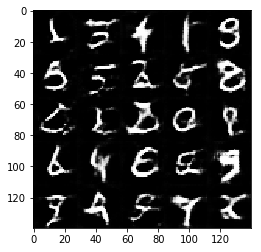

Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 1.7948... Generator Loss: 1.7332
Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 1.4079
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.5359... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 1.1791
Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 1.3740
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.6818


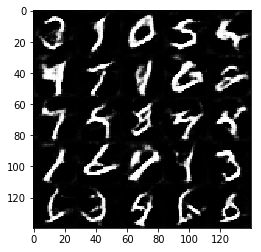

Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 1.3126
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 1.1699
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 1.1498
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 1.0142
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 1.1856
Epoch 1/2... Discriminator Loss: 1.5234... Generator Loss: 0.4809
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.7187... Generator Loss: 0.6050
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.5813


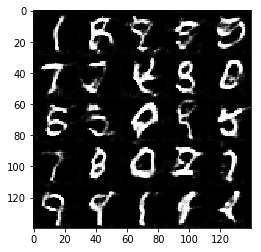

Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 1.0193
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 1.2868
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 1.2541
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 1.4966... Generator Loss: 1.3132
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.8483
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 1.4592
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 1.4414


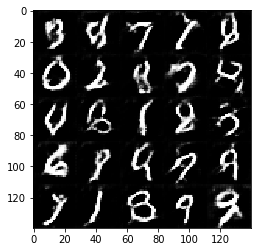

Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 1.3853
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.8882
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.9710
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 1.5015... Generator Loss: 1.5092
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.8448


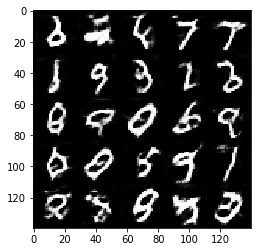

Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 1.3455
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 2.1210
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 1.0630
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 1.2361
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 1.3756
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.5677... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 1.7608... Generator Loss: 0.5967
Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 0.8768


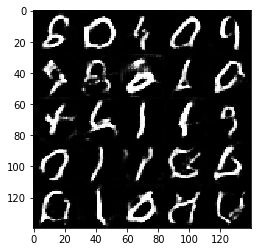

Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 1.2418
Epoch 1/2... Discriminator Loss: 1.5235... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 1.3646
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 1.2448
Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.8999
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.9302


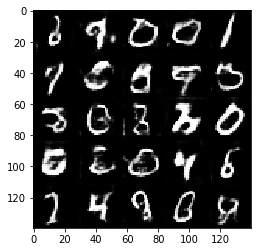

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.8425
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 1.1308
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 1.0521


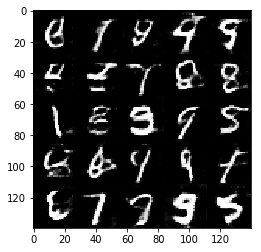

Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 1.2079
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 1.3785... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.7460... Generator Loss: 0.4977
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.6193... Generator Loss: 0.5118


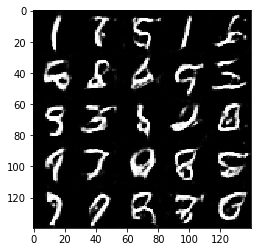

Epoch 2/2... Discriminator Loss: 1.5470... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 1.4311... Generator Loss: 0.5669
Epoch 2/2... Discriminator Loss: 1.4651... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 1.3024
Epoch 2/2... Discriminator Loss: 1.5145... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 1.5568


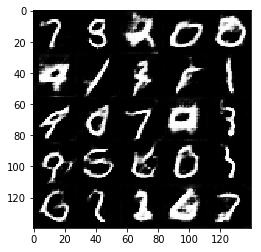

Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.5931... Generator Loss: 0.8851
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 1.5800... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.9784
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 1.1788


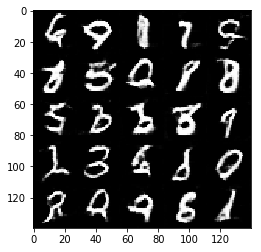

Epoch 2/2... Discriminator Loss: 1.5306... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.9296
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 1.0647
Epoch 2/2... Discriminator Loss: 1.8543... Generator Loss: 0.3893
Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 1.0876
Epoch 2/2... Discriminator Loss: 1.3785... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.9348
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.7016


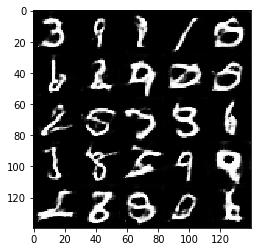

Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.9965
Epoch 2/2... Discriminator Loss: 2.0158... Generator Loss: 0.5860
Epoch 2/2... Discriminator Loss: 1.5978... Generator Loss: 0.8828
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 1.1237
Epoch 2/2... Discriminator Loss: 1.5742... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.4560... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 1.4869... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 1.5248... Generator Loss: 1.0310


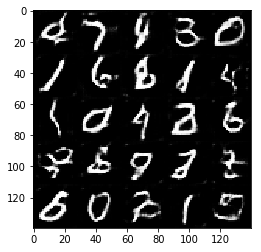

Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 1.1140
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.9292
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 1.1915
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.8110
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 1.0232
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.9655
Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 1.3271


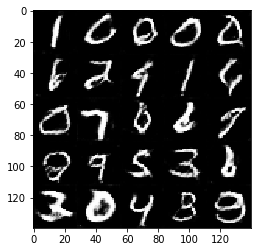

Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 1.5780
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 1.1708
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 1.4010
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 1.4174
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 1.0548
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 1.1899


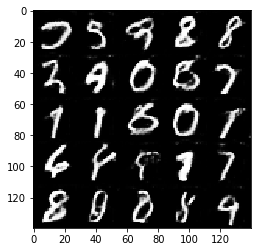

Epoch 2/2... Discriminator Loss: 1.5408... Generator Loss: 0.6481
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 1.2978
Epoch 2/2... Discriminator Loss: 1.1619... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.5529... Generator Loss: 2.1424
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 1.4092
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.5172... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.9550


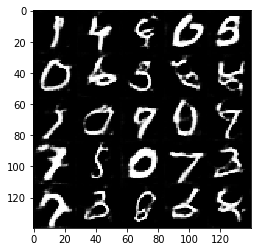

Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 1.1017
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.9681
Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 1.6814
Epoch 2/2... Discriminator Loss: 1.5900... Generator Loss: 1.6254
Epoch 2/2... Discriminator Loss: 1.5967... Generator Loss: 1.4561
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.9453
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 0.9670
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.7040
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.9264


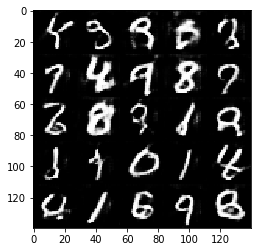

Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 1.1402
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 1.4322
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 1.6222
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 0.9468
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.9426
Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 0.6337


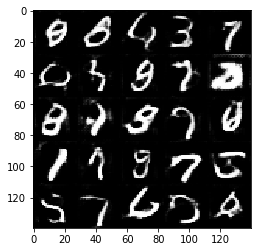

Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.2441... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 1.1202
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 1.1338
Epoch 2/2... Discriminator Loss: 1.4972... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 1.6026... Generator Loss: 1.6093
Epoch 2/2... Discriminator Loss: 1.2717... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.4915... Generator Loss: 1.4175
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.9609


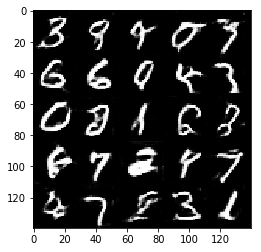

Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.9100
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.5397... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.9761
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.9746
Epoch 2/2... Discriminator Loss: 1.5028... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 1.3652


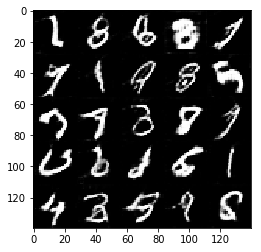

Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 1.2378
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 1.2110
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 1.0485
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 1.4660... Generator Loss: 0.8829


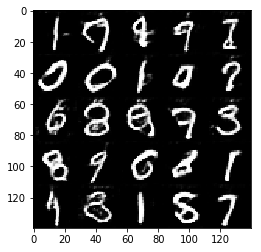

Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 1.0131
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 1.2009
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.9628
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.9879
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.9627
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 1.1469
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 1.2566


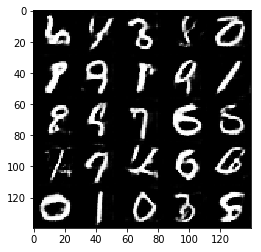

Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.8111
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.9526
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.9633


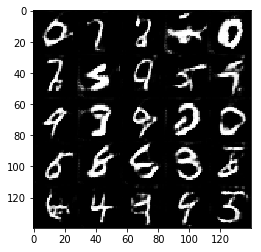

Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.9416
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.9379
Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 1.4312
Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.8363
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.8900


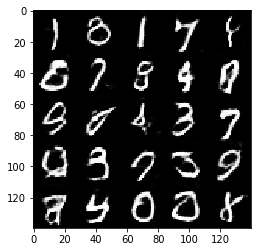

Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 1.3276
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 1.0214
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.9137
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 1.3221
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 1.0348


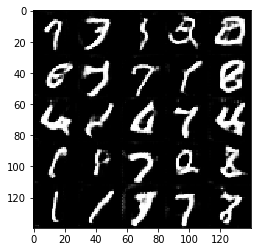

Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 1.1855
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 1.2216
Epoch 2/2... Discriminator Loss: 1.5198... Generator Loss: 0.7112


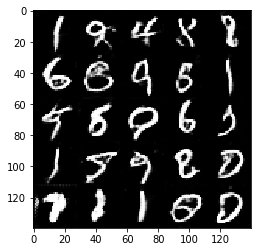

Done


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

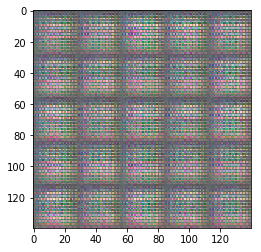

Epoch 1/1... Discriminator Loss: 15.0940... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 7.6945
Epoch 1/1... Discriminator Loss: 8.0764... Generator Loss: 0.0521
Epoch 1/1... Discriminator Loss: 5.0290... Generator Loss: 9.0631
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 3.0992
Epoch 1/1... Discriminator Loss: 1.8701... Generator Loss: 0.2717
Epoch 1/1... Discriminator Loss: 4.5636... Generator Loss: 0.0363
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 5.5990... Generator Loss: 5.7615


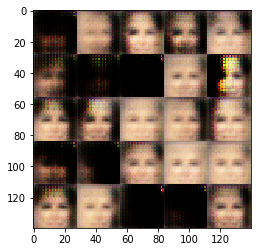

Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 3.8163
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 2.8935
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.3733
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 4.2736
Epoch 1/1... Discriminator Loss: 2.2981... Generator Loss: 4.9069
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 1.8080
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 2.1410
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 4.1089
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 1.9097


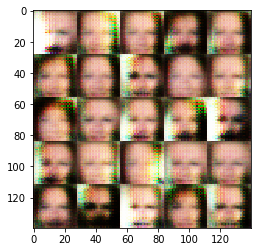

Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 2.9580
Epoch 1/1... Discriminator Loss: 2.4606... Generator Loss: 2.0432
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 1.6873
Epoch 1/1... Discriminator Loss: 2.9403... Generator Loss: 3.5267
Epoch 1/1... Discriminator Loss: 2.1307... Generator Loss: 2.7296
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 2.6411
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 0.4651... Generator Loss: 1.8146
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 3.2072
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.3685


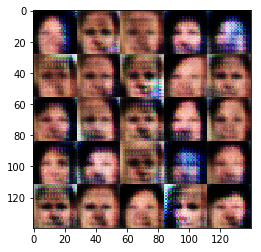

Epoch 1/1... Discriminator Loss: 2.1585... Generator Loss: 4.2088
Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 2.8922
Epoch 1/1... Discriminator Loss: 1.7667... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 1.7400... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 6.3444... Generator Loss: 6.4041
Epoch 1/1... Discriminator Loss: 2.2560... Generator Loss: 0.2012
Epoch 1/1... Discriminator Loss: 5.7700... Generator Loss: 5.1564


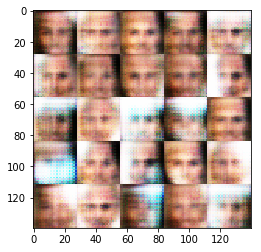

Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 0.3233... Generator Loss: 1.9521
Epoch 1/1... Discriminator Loss: 2.2996... Generator Loss: 4.2710
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 3.1246
Epoch 1/1... Discriminator Loss: 3.9817... Generator Loss: 5.2186
Epoch 1/1... Discriminator Loss: 1.8703... Generator Loss: 2.2557
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 1.4290


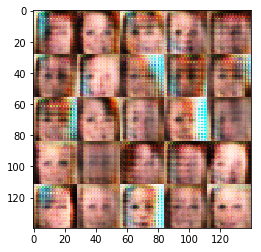

Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 1.9241
Epoch 1/1... Discriminator Loss: 4.2550... Generator Loss: 4.4895
Epoch 1/1... Discriminator Loss: 2.6799... Generator Loss: 6.0405
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 1.3689
Epoch 1/1... Discriminator Loss: 7.6102... Generator Loss: 7.7330
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 2.0616
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.3633


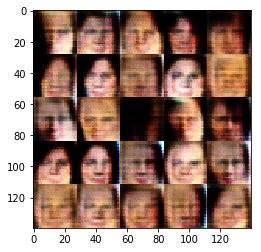

Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 2.2636
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 2.1947... Generator Loss: 0.2409
Epoch 1/1... Discriminator Loss: 1.7916... Generator Loss: 4.5034
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.7477
Epoch 1/1... Discriminator Loss: 1.9385... Generator Loss: 0.2386
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 3.8661
Epoch 1/1... Discriminator Loss: 1.6777... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 0.7533


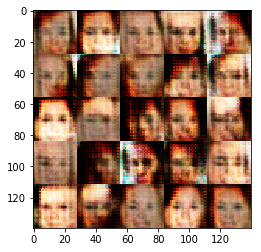

Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 2.3989
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.5581
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.7023
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.3024
Epoch 1/1... Discriminator Loss: 2.0882... Generator Loss: 0.2966
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 2.5689
Epoch 1/1... Discriminator Loss: 2.8059... Generator Loss: 0.1542
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 2.1558... Generator Loss: 0.2106


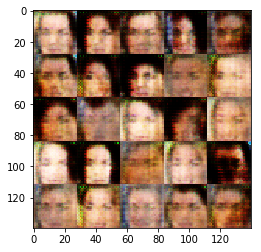

Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.3579
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.4334
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 2.1008
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.8374


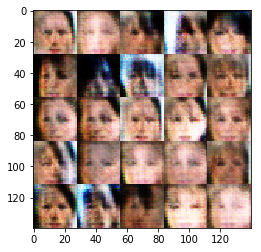

Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.4448
Epoch 1/1... Discriminator Loss: 2.0171... Generator Loss: 0.2490
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.2485
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 2.8288... Generator Loss: 3.3710
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.9044


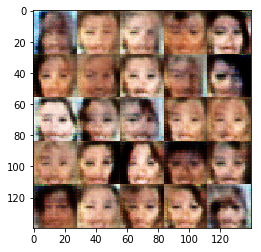

Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 2.5935... Generator Loss: 0.1544
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 1.8596
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.5146


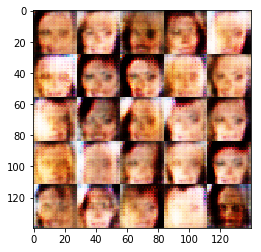

Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.7750... Generator Loss: 0.2784
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.3142
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 0.9606


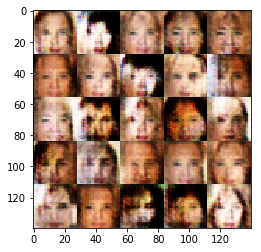

Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 5.1686... Generator Loss: 2.9966
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 2.6391
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.6469


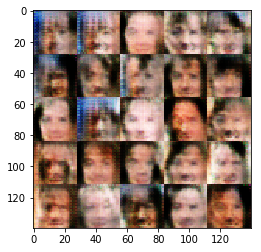

Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9053


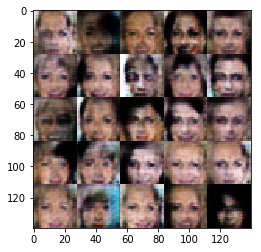

Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 2.1590... Generator Loss: 0.1865
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.4363
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 2.0515
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.3749


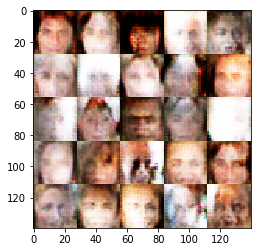

Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.7366
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.2041


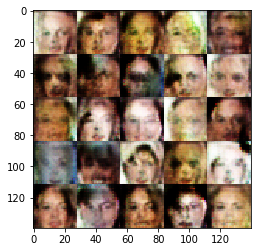

Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 1.7245... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 2.0412... Generator Loss: 0.2076


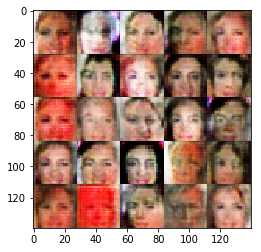

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 2.1041
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 0.8936


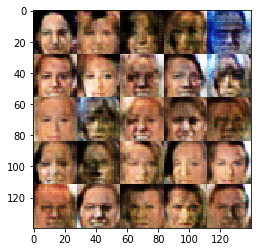

Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 2.8803
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.0920


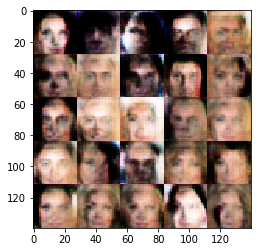

Epoch 1/1... Discriminator Loss: 2.4713... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.4308
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 0.2773
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 2.7891... Generator Loss: 0.1242
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.8627


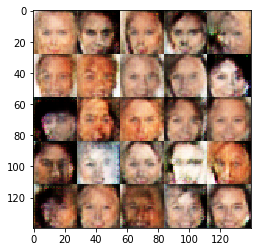

Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.2863
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 0.9677


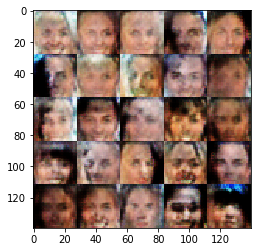

Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.7623... Generator Loss: 2.3725
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.7782... Generator Loss: 2.1154
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 1.9614


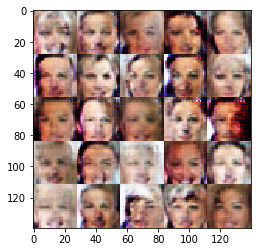

Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.5235
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.7150... Generator Loss: 1.7497
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.2896
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.5772


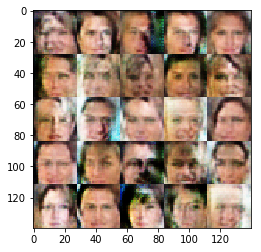

Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 1.3817
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.9041
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.4774
Epoch 1/1... Discriminator Loss: 2.5895... Generator Loss: 0.1342


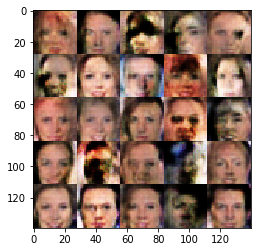

Epoch 1/1... Discriminator Loss: 1.8712... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.8347... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 2.5753... Generator Loss: 0.1150
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.6568... Generator Loss: 2.1574
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.4126


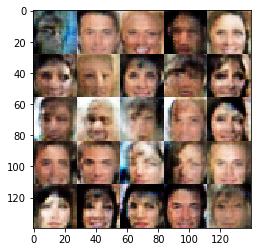

Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 2.9703... Generator Loss: 3.2039
Epoch 1/1... Discriminator Loss: 2.1023... Generator Loss: 2.3309
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.9591


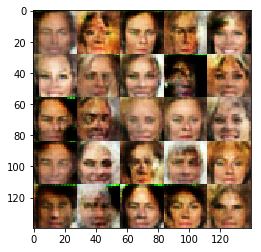

Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 1.3495


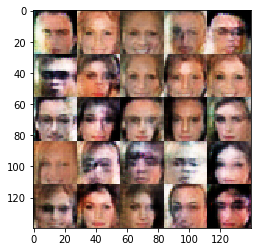

Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.8037
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.9457... Generator Loss: 2.1565
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.6927


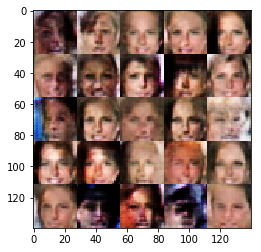

Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.5705
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.9220
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 2.3908... Generator Loss: 0.1524
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.8363


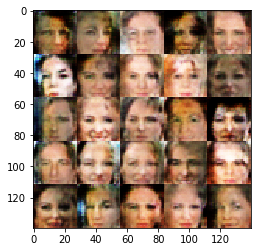

Epoch 1/1... Discriminator Loss: 3.1249... Generator Loss: 1.8405
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 2.8617
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.6356


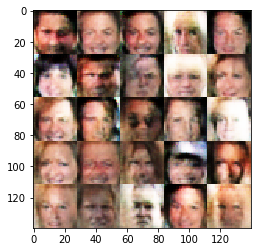

Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 1.3913


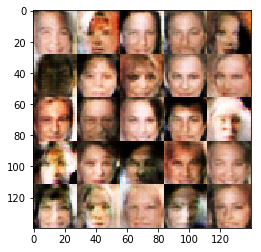

Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.6521


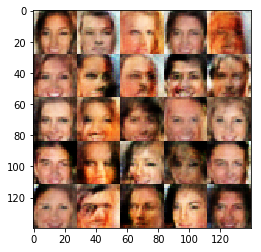

Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 2.1492
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 0.8778


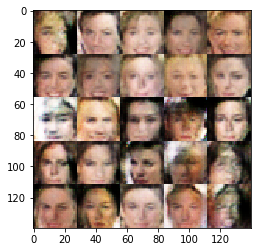

Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 2.0654
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 2.3839... Generator Loss: 0.2697
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 1.2460


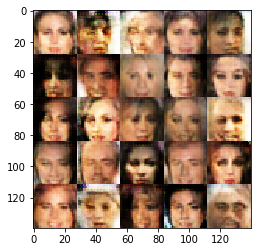

Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.6934... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 0.7275


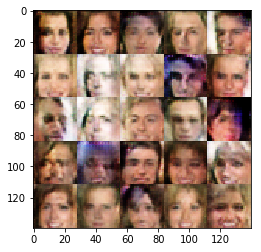

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 1.6533
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 1.1118


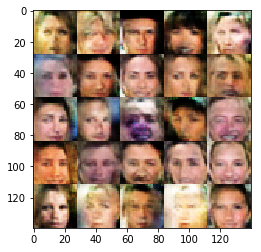

Epoch 1/1... Discriminator Loss: 1.6998... Generator Loss: 1.8345
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 1.3411


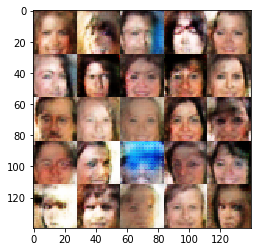

Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.6205


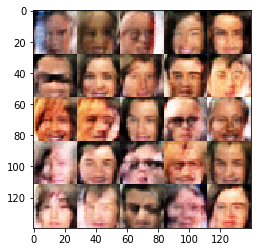

Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 1.7397
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.9627


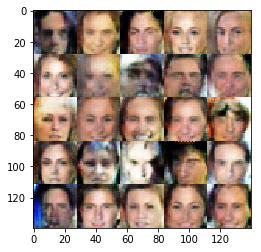

Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.3915
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7826


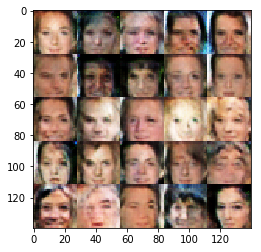

Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 2.4052... Generator Loss: 0.1586
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.3037
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5160


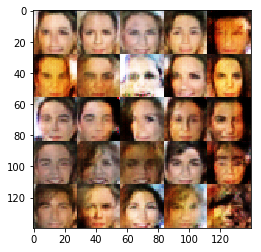

Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 2.0026


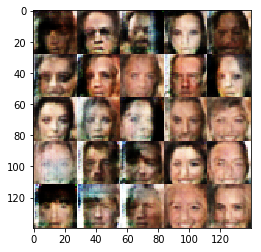

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.5089
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 1.6300
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.1625


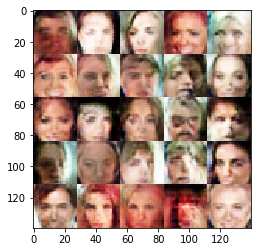

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.3946
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7093


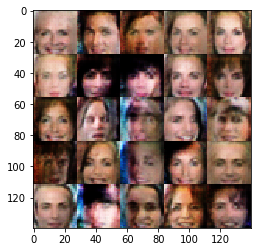

Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.7693... Generator Loss: 1.9728
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 0.2888... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 1.4541


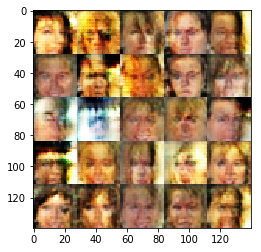

Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 2.2240
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.9486
Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7003


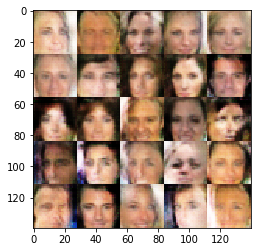

Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 2.6829


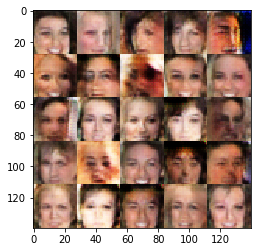

Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.3771
Epoch 1/1... Discriminator Loss: 1.9042... Generator Loss: 0.2564
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8618


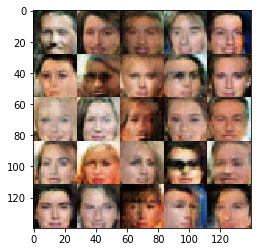

Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.7378


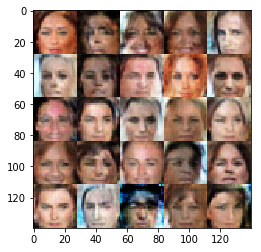

Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 0.2780... Generator Loss: 1.9543
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 1.9427
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 1.6497


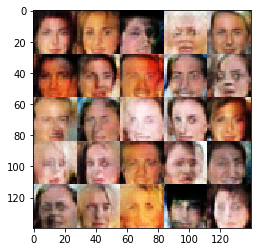

Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0479


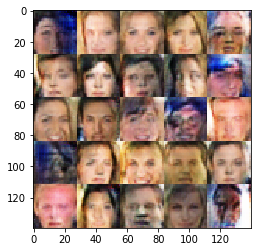

Epoch 1/1... Discriminator Loss: 0.3969... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 2.2147... Generator Loss: 0.1794
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.1110


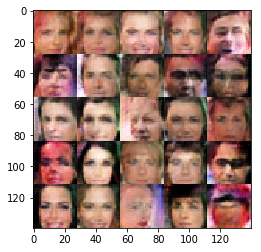

Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 2.5734
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.2552
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 1.5217
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 1.2483


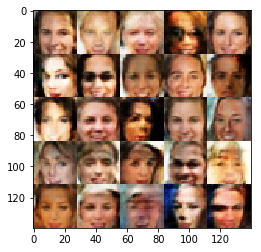

Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.4417


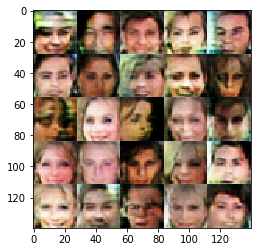

Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.5050
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 1.8711
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.3237
Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.3606


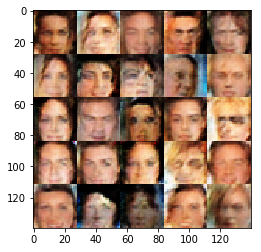

Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 0.9057


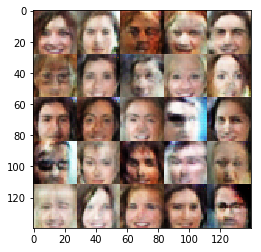

Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.6460
Epoch 1/1... Discriminator Loss: 1.6875... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.1564
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.8221
Epoch 1/1... Discriminator Loss: 2.6199... Generator Loss: 0.1341
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 2.4083


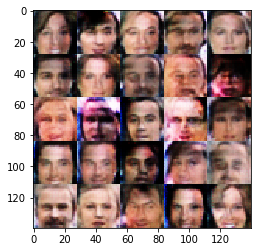

Epoch 1/1... Discriminator Loss: 0.3004... Generator Loss: 2.3183
Epoch 1/1... Discriminator Loss: 1.9432... Generator Loss: 3.1317
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.4226


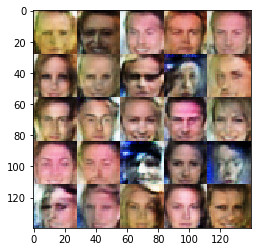

Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.3946
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.1004


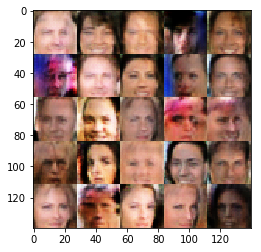

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.7566... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 1.7389
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.6254
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.6360


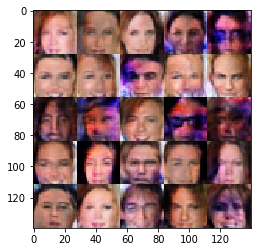

Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 2.2729
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 2.0051
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 2.5501
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.6909


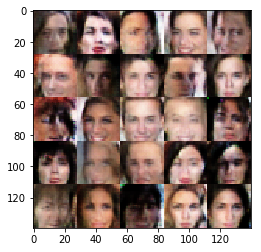

Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 1.6672
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 1.7889... Generator Loss: 0.2283


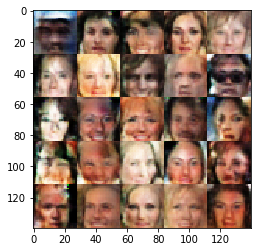

Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 1.5775
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 2.0737
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.8286
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 1.6998... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.5888


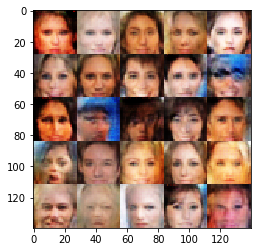

Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.3329


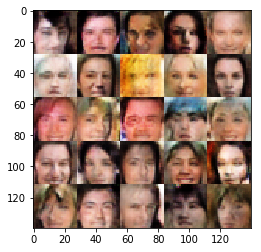

Done


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.